## Data description

In [1]:
%%bash
parent_path=$(cd ../ && pwd)
cd ../ && pwd

/mnt/c/Users/marci/Desktop/Python/House-Prices


In [2]:
! pip install category_encoders

## Load dataset

In [3]:
import pandas as pd
from pathlib import Path
#pd.options.mode.chained_assignment = None 
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')
plt.rcParams.update({'figure.max_open_warning': 100})
from category_encoders.one_hot import OneHotEncoder

In [4]:
dataset_path = Path().absolute().parent / 'dataset'

In [5]:
train_data_path = dataset_path  / 'train.csv'

In [6]:
data = pd.read_csv(train_data_path, index_col=0)
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


## Cleaning data

In [7]:
null_columns = data.columns[data.isnull().sum() > 0]

In [8]:
def color_negative_red(val):
    color = 'red' if val > 0.03 else 'black'
    return 'color: %s' % color

In [9]:
null_values_df = pd.DataFrame(data[null_columns].isnull().sum().divide(len(data)), columns=['Null values'])

In [10]:
null_values_df.style.applymap(color_negative_red)

,Null values
LotFrontage,0.177397
Alley,0.937671
MasVnrType,0.005479
MasVnrArea,0.005479
BsmtQual,0.025342
BsmtCond,0.025342
BsmtExposure,0.026027
BsmtFinType1,0.025342
BsmtFinType2,0.026027
Electrical,0.000685


In [11]:
delete_columns = null_values_df[null_values_df['Null values']>0.03].index.values.tolist()
delete_columns

['LotFrontage',
 'Alley',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

## Exploring data types

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
data.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

## Preprocessing

In [14]:
def preprocess_data(data, train=True, ohe=None):
    if train:
        data = data.copy()

        delete_columns = ['LotFrontage', 'Alley', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                          'GarageQual', 'GarageCond', 'PoolQC', 'Fence','MiscFeature']

        data = data.drop(delete_columns, axis=1)

        object_columns = (data.dtypes == object)
        numerical_columns = (data.dtypes != object)

        imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imputer_num = SimpleImputer(missing_values=np.nan, strategy='mean')

        data.iloc[:,:] = imputer_cat.fit_transform(data)
        data.iloc[:,:] = imputer_cat.fit_transform(data)
        for column in data.columns[object_columns]:
            data[column] = pd.Categorical(data[column])

        
        ohe = OneHotEncoder(cols=data.columns[object_columns])
        data_ohe = ohe.fit_transform(data.drop(['SalePrice'], axis=1)) 
        data_ohe['SalePrice'] = data['SalePrice']
        return data_ohe, ohe
    else:
        data = data.copy()

        delete_columns = ['LotFrontage', 'Alley', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                          'GarageQual', 'GarageCond', 'PoolQC', 'Fence','MiscFeature']

        data = data.drop(delete_columns, axis=1)

        object_columns = (data.dtypes == object)
        numerical_columns = (data.dtypes != object)

        imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imputer_num = SimpleImputer(missing_values=np.nan, strategy='mean')

        data.iloc[:,:] = imputer_cat.fit_transform(data)
        data.iloc[:,:] = imputer_cat.fit_transform(data)
        return ohe.transform(data)

In [15]:
def skew_transform_data(data):
    data = data.copy()
    numerical_columns = data.columns[(data.dtypes != object)]
    if 'SalePrice' in numerical_columns:
        numerical_columns = numerical_columns.drop('SalePrice')
    skew_limit = 0
    skew_vals = data[numerical_columns].skew()
    skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))
    for col in skew_cols.index.tolist():
        data[col] = np.log1p(data[col])
        
    return data

### Example of skewed data

In [16]:
data = pd.read_csv(train_data_path, index_col=0)
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [17]:
data_preprocess, ohe = preprocess_data(data)
data_preprocess

,MSSubClass,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,LotArea,Street_1,Street_2,LotShape_1,...,SaleType_7,SaleType_8,SaleType_9,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,1,0,0,0,0,8450,1,0,1,...,0,0,0,1,0,0,0,0,0,208500
2,20,1,0,0,0,0,9600,1,0,1,...,0,0,0,1,0,0,0,0,0,181500
3,60,1,0,0,0,0,11250,1,0,0,...,0,0,0,1,0,0,0,0,0,223500
4,70,1,0,0,0,0,9550,1,0,0,...,0,0,0,0,1,0,0,0,0,140000
5,60,1,0,0,0,0,14260,1,0,0,...,0,0,0,1,0,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,1,0,0,0,0,7917,1,0,1,...,0,0,0,1,0,0,0,0,0,175000
1457,20,1,0,0,0,0,13175,1,0,1,...,0,0,0,1,0,0,0,0,0,210000
1458,70,1,0,0,0,0,9042,1,0,1,...,0,0,0,1,0,0,0,0,0,266500


In [18]:
data_skew_transformed = skew_transform_data(data_preprocess)

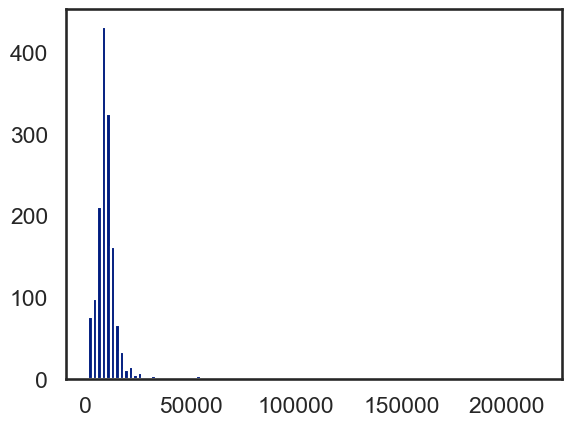

In [36]:
plt.hist(data_preprocess['LotArea'], bins=100);

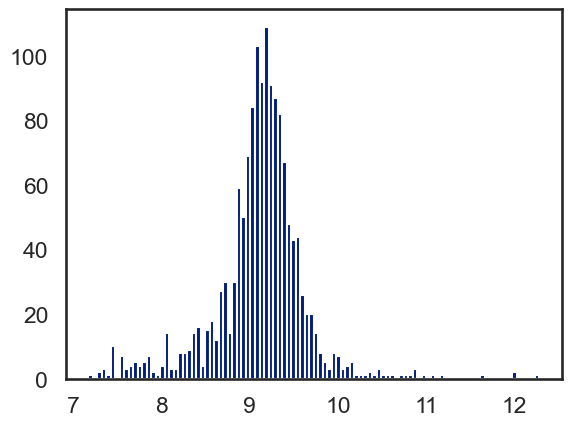

In [37]:
plt.hist(data_skew_transformed['LotArea'], bins=100);

## Dividing into dependent and independt variable

In [21]:
data = pd.read_csv(train_data_path, index_col=0)
data_preprocess, ohe = preprocess_data(data)
X = data_preprocess.drop(['SalePrice'],axis=1)
y = data_preprocess['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
X_train_with_skew = skew_transform_data(X_train)
X_test_with_skew = skew_transform_data(X_test)

### Plot function

In [23]:
def plot(y_test, y_pred):
    ax = plt.axes()
    data = pd.DataFrame({'y_test':y_test, 'y_pred': y_pred})
    sns.regplot(x = 'y_test', y = 'y_pred', data=data,ci=100)
    lim = (0, y_test.max()+10000)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
    r2 = r2_score(y_test, y_pred)
    ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title=f"RMSE: {rmse:.2} R2: {r2:.2}");
    ax.grid()

## Linear Regression test

In [24]:
def test_lin_reg(X_train,y_train, X_test, y_test, skew=False):
    if skew:
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, np.log1p(y_train))
        y_pred_test = lin_reg.predict(X_test)
        y_pred_test = np.expm1(y_pred_test)
    else:
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        y_pred_test = lin_reg.predict(X_test)

    plot(y_test, y_pred_test)
    return lin_reg

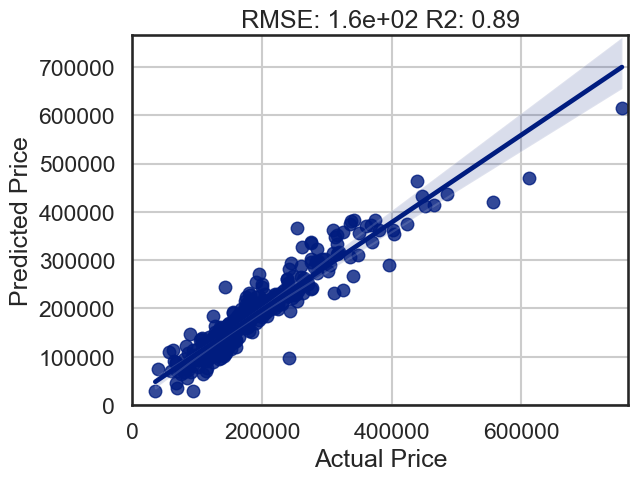

In [25]:
lin_reg = test_lin_reg(X_train,y_train, X_test, y_test)

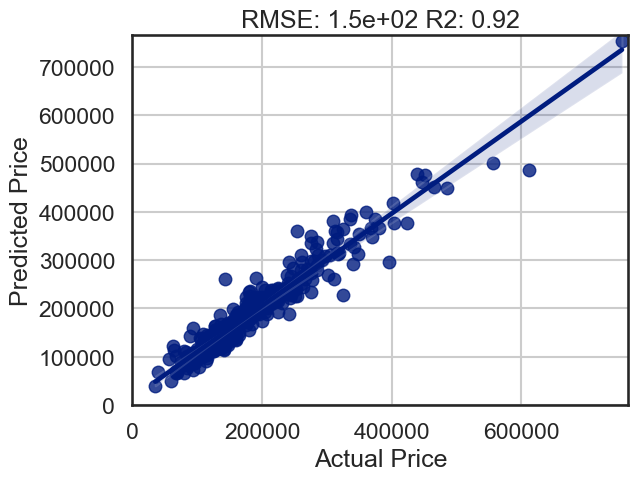

In [26]:
lin_reg_skew = test_lin_reg(X_train_with_skew , y_train, X_test_with_skew , y_test, skew=True)

## Test Elastic Net CV

In [46]:
def test_elastic_net(X_train,y_train, X_test, y_test, skew=False):
    l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
    if skew:
        elastic_net = ElasticNetCV(cv=5, random_state=0, l1_ratio=l1_ratio, tol=1e-5)
        elastic_net.fit(X_train, np.log1p(y_train))
        y_pred_test =  elastic_net.predict(X_test)
        y_pred_test = np.expm1(y_pred_test)
    else:
        elastic_net = ElasticNetCV(cv=5, random_state=0, l1_ratio=l1_ratio)
        elastic_net.fit(X_train, y_train)
        y_pred_test =  elastic_net.predict(X_test)

    ax = plt.axes()
    data = pd.DataFrame({'y_test':y_test, 'y_pred': y_pred_test})
    sns.regplot(x = 'y_test', y = 'y_pred', data=data,ci=100)
    lim = (0, y_test.max())

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test, squared=False))
    r2 = r2_score(y_test, y_pred_test)
    ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title=f"RMSE: {rmse:.2} R2: {r2:.2}");
    ax.grid()
    return elastic_net

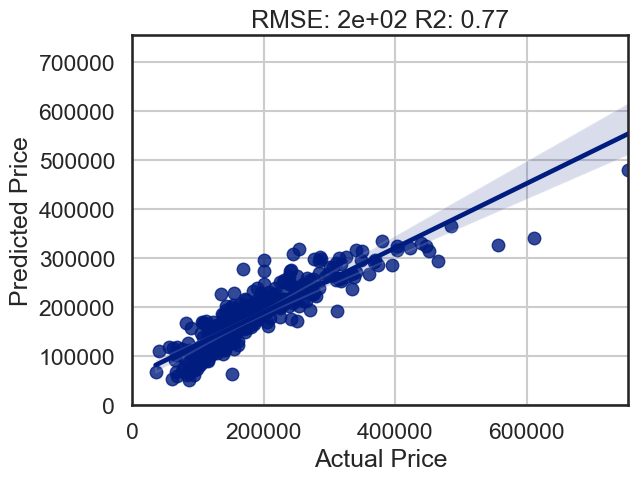

In [47]:
lin_reg = test_elastic_net(X_train,y_train, X_test, y_test)

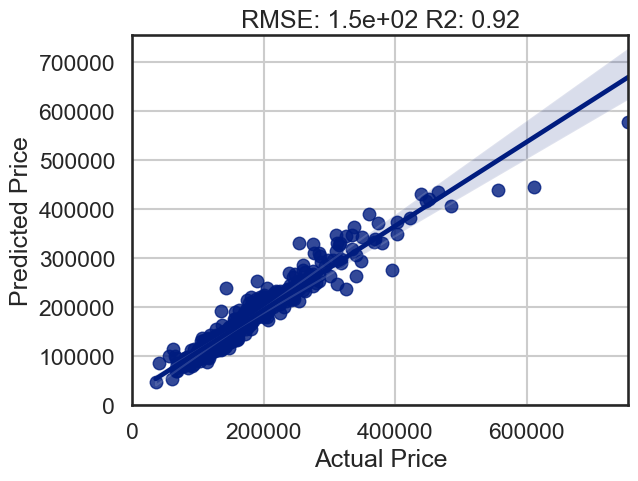

In [48]:
lin_reg_skew = test_elastic_net(X_train_with_skew , y_train, X_test_with_skew , y_test, skew=True)

## Model parameters

In [49]:
lin_reg_skew.alpha_

0.0004076611440408984

In [50]:
lin_reg_skew.n_iter_

141

In [51]:
lin_reg_skew.l1_ratio_

1.0

## Test data

In [52]:
def test_submission(model, X_train, filename='sample_submission', skew = False, ohe=ohe):
    test_data_path = Path().absolute().parent / 'dataset' / 'test.csv'
    data_test = pd.read_csv(test_data_path, index_col = 0)
    X_submission_test= preprocess_data(data_test, train=False, ohe=ohe)
    
    if skew:
        X_submission_test = skew_transform_data(X_submission_test)
        y_test_submission = model.predict(X_submission_test)
        y_test_submission = np.expm1(y_test_submission)
        pd.DataFrame({'Id': data_test.index, 'SalePrice': y_test_submission}).to_csv(filename+'.csv', index=False)
        return X_train, X_submission_test
    

In [53]:
X_train, X_submission_test = test_submission(lin_reg_skew,X_train = X_train ,filename='test', skew = True)